In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error


base_path = '.'

In [2]:
# Modify csv to follow same pattern

# Content based
# results_uwarm_iwarm = pd.read_csv(f'{base_path}\\content-based\\content-based_warm_user_warm_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_uwarm_icold = pd.read_csv(f'{base_path}\\content-based\\content-based_warm_user_cold_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_ucold_uwarm = pd.read_csv(f'{base_path}\\content-based\\content-based_cold_user_warm_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_ucold_icold = pd.read_csv(f'{base_path}\\content-based\\content-based_cold_user_cold_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_uwarm_iwarm.to_csv(f'{base_path}\\content-based\\content-based_warm_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_uwarm_icold.to_csv(f'{base_path}\\content-based\\content-based_warm_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_uwarm.to_csv(f'{base_path}\\content-based\\content-based_cold_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_icold.to_csv(f'{base_path}\\content-based\\content-based_cold_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])

# Graph based
# results_uwarm_iwarm = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_warm_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_uwarm_icold = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_cold_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_ucold_uwarm = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_warm_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_ucold_icold = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_cold_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_uwarm_iwarm.to_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_uwarm_icold.to_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_uwarm.to_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_icold.to_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])

In [25]:

def evaluate_topk_fast(df, k):
    df = df.copy()

    # Filter users with at least k items
    user_counts = df['UserID'].value_counts()
    valid_users = user_counts[user_counts >= k].index
    df = df[df['UserID'].isin(valid_users)]

    # Recompute row_number after filtering
    df = df.sort_values(['UserID', 'Rank_pred'], ascending=[True, True])
    df['row_number'] = df.groupby('UserID').cumcount()
    topk_df = df[df['row_number'] < k].copy()

    # Precision@k
    precision = topk_df.groupby('UserID')['Relevance'].mean().mean()

    # Recall@k
    relevant_per_user = df.groupby('UserID')['Relevance'].sum()
    hits_per_user = topk_df.groupby('UserID')['Relevance'].sum()
    recall = (hits_per_user / relevant_per_user).fillna(0).mean()

    # HitRate@k
    hits = (hits_per_user > 0).astype(int)
    hit_rate = hits.mean()

    # nDCG@k
    def dcg(rels):
        return np.sum(rels / np.log2(np.arange(2, len(rels) + 2)))

    def ndcg_per_user(x):
        dcg_val = dcg(x['Relevance'].values)
        ideal = dcg(sorted(x['Relevance'].values, reverse=True)[:k])
        return dcg_val / ideal if ideal > 0 else 0

    ndcg = topk_df.groupby('UserID').apply(ndcg_per_user, include_groups=False).mean()

    return {
        f'Precision@{k}': precision,
        f'Recall@{k}': recall,
        f'HitRate@{k}': hit_rate,
        f'nDCG@{k}': ndcg
    }


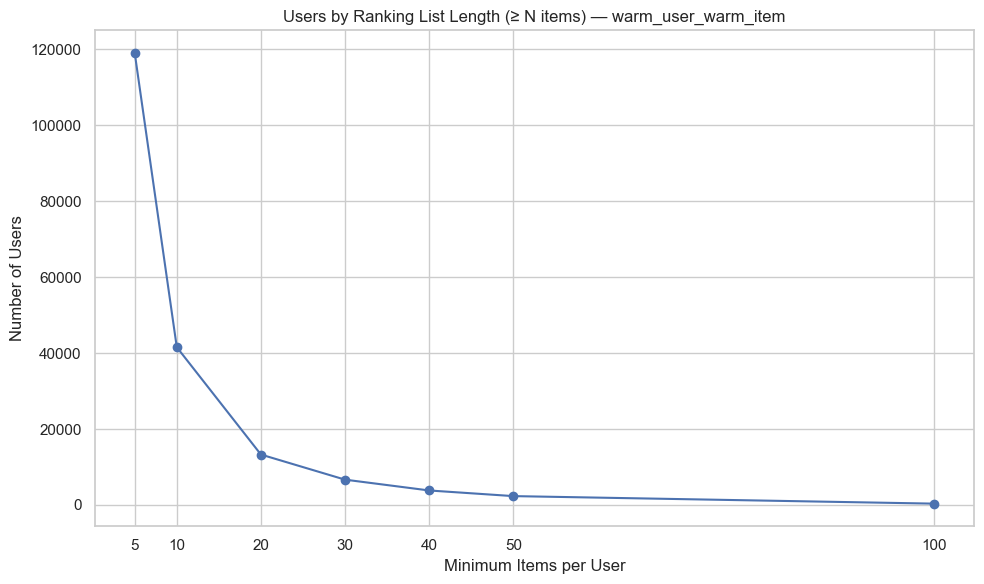

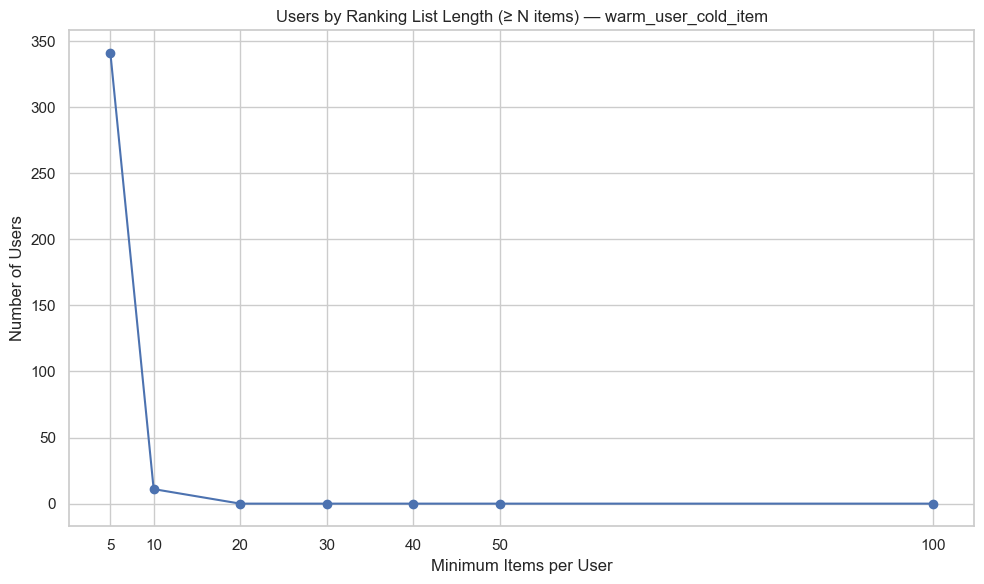

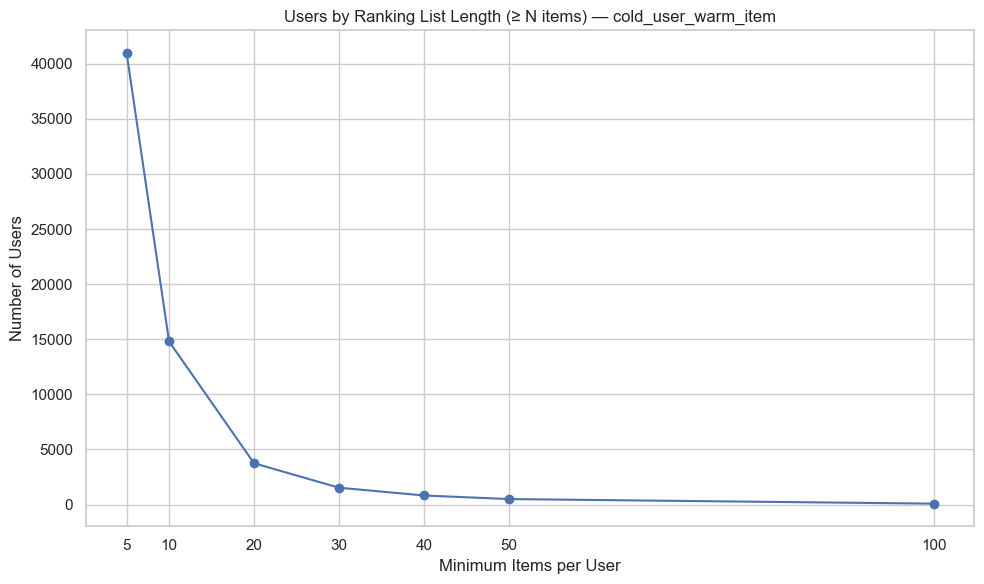

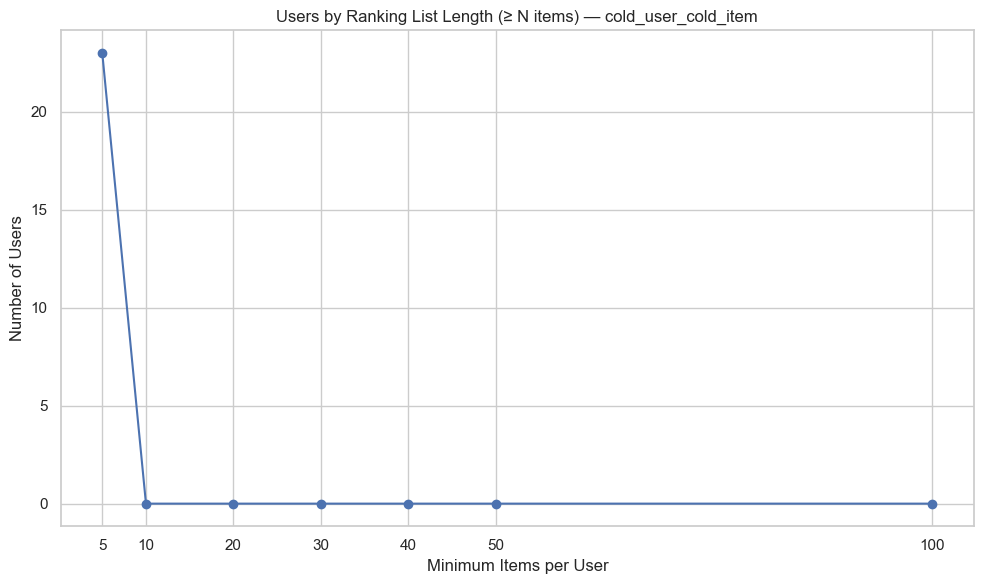

In [26]:

def plot_user_count_by_ranking_length(testsets_dict, thresholds=[5, 10, 20, 30, 40, 50, 100]):
    """
    For each testset, plot number of users whose ranking list (ratings count) is >= each threshold.
    
    Parameters:
    - testsets_dict: dict[str, pd.DataFrame] with 'UserID' column
    - thresholds: list[int] of minimum ranking list lengths to check
    """
    for testset_name, df in testsets_dict.items():
        # Count how many items each user rated (ranking list length)
        counts = df['UserID'].value_counts()

        # Count number of users meeting or exceeding each threshold
        user_counts = [sum(counts >= t) for t in thresholds]

        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, user_counts, marker='o')
        plt.title(f'Users by Ranking List Length (≥ N items) — {testset_name}')
        plt.xlabel('Minimum Items per User')
        plt.ylabel('Number of Users')
        plt.grid(True)
        plt.xticks(thresholds)
        plt.tight_layout()
        plt.show()

test_uwarm_iwarm = pd.read_csv(f'{base_path}\\testset_warm_user_warm_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_uwarm_icold = pd.read_csv(f'{base_path}\\testset_warm_user_cold_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_ucold_iwarm = pd.read_csv(f'{base_path}\\testset_cold_user_warm_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_ucold_icold = pd.read_csv(f'{base_path}\\testset_cold_user_cold_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])

testsets_dict = {
    'warm_user_warm_item': test_uwarm_iwarm,
    'warm_user_cold_item': test_uwarm_icold,
    'cold_user_warm_item': test_ucold_iwarm,
    'cold_user_cold_item': test_ucold_icold
}

# Plot rating volume by user count group
plot_user_count_by_ranking_length(testsets_dict)

    
    

In [7]:
# Load the test sets
print('Loading test sets...')
test_uwarm_iwarm = pd.read_csv(f'{base_path}\\testset_warm_user_warm_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_uwarm_icold = pd.read_csv(f'{base_path}\\testset_warm_user_cold_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_ucold_iwarm = pd.read_csv(f'{base_path}\\testset_cold_user_warm_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_ucold_icold = pd.read_csv(f'{base_path}\\testset_cold_user_cold_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])

# Models
models = ['content-based', 'svd', 'hybrid-lgbm', 'hybrid-xgb', 'graph-sage']

# Test set types
testsets = ['hot user, hot wine', 'hot user, cold wine', 'cold user, hot wine', 'cold user, cold wine']
# k values for top-k evaluation
ks = [5, 10, 20, 50]
relevance_threshold = 3.5
results = {}


for model in models:
    results[model] = {
        'regression': {
            'mse': {},
            'rmse': {},
            'mae': {}
            },
        'top-k': {
            'precision@5': {},
            'recall@5': {},
            'hitrate@5': {},
            'ndcg@5': {},
            'precision@10': {},
            'recall@10': {},
            'hitrate@10': {},
            'ndcg@10': {},
            'precision@20': {},
            'recall@20': {},
            'hitrate@20': {},
            'ndcg@20': {},
            'precision@50': {},
            'recall@50': {},
            'hitrate@50': {},
            'ndcg@50': {}
        }
        }
    
    # Load the results for each test set
    print(f'Loading results for {model}...')

    results_uwarm_iwarm = pd.read_csv(f'{base_path}\\{model}\\{model}_warm_user_warm_item.csv', header= 0, names=['RatingID','Rating_pred'])
    results_uwarm_icold = pd.read_csv(f'{base_path}\\{model}\\{model}_warm_user_cold_item.csv', header= 0, names=['RatingID','Rating_pred'])
    results_ucold_iwarm = pd.read_csv(f'{base_path}\\{model}\\{model}_cold_user_warm_item.csv', header= 0, names=['RatingID','Rating_pred'])
    results_ucold_icold = pd.read_csv(f'{base_path}\\{model}\\{model}_cold_user_cold_item.csv', header= 0, names=['RatingID','Rating_pred'])
    
    # Merge the results with the test set
    print('Merging results with test set...')
    results_uwarm_iwarm = results_uwarm_iwarm.merge(test_uwarm_iwarm, on='RatingID', how='left')
    results_uwarm_icold = results_uwarm_icold.merge(test_uwarm_icold, on='RatingID', how='left')
    results_ucold_iwarm = results_ucold_iwarm.merge(test_ucold_iwarm, on='RatingID', how='left')
    results_ucold_icold = results_ucold_icold.merge(test_ucold_icold, on='RatingID', how='left')
    
    # Calculate the MSE, RMSE and MAE for each test set
    print('Calculating MSE, RMSE and MAE...')
    # Hot user, hot wine
    results[model]['regression']['mse'][testsets[0]] = mean_squared_error(results_uwarm_iwarm['Rating'], results_uwarm_iwarm['Rating_pred'])
    results[model]['regression']['rmse'][testsets[0]] = root_mean_squared_error(results_uwarm_iwarm['Rating'], results_uwarm_iwarm['Rating_pred'])
    results[model]['regression']['mae'][testsets[0]] = mean_absolute_error(results_uwarm_iwarm['Rating'], results_uwarm_iwarm['Rating_pred'])
    # Hot user, cold wine
    results[model]['regression']['mse'][testsets[1]] = mean_squared_error(results_uwarm_icold['Rating'], results_uwarm_icold['Rating_pred'])
    results[model]['regression']['rmse'][testsets[1]] = root_mean_squared_error(results_uwarm_icold['Rating'], results_uwarm_icold['Rating_pred'])
    results[model]['regression']['mae'][testsets[1]] = mean_absolute_error(results_uwarm_icold['Rating'], results_uwarm_icold['Rating_pred'])
    # Cold user, hot wine
    results[model]['regression']['mse'][testsets[2]] = mean_squared_error(results_ucold_iwarm['Rating'], results_ucold_iwarm['Rating_pred'])
    results[model]['regression']['rmse'][testsets[2]] = root_mean_squared_error(results_ucold_iwarm['Rating'], results_ucold_iwarm['Rating_pred'])
    results[model]['regression']['mae'][testsets[2]] = mean_absolute_error(results_ucold_iwarm['Rating'], results_ucold_iwarm['Rating_pred'])
    # Cold user, cold wine
    results[model]['regression']['mse'][testsets[3]] = mean_squared_error(results_ucold_icold['Rating'], results_ucold_icold['Rating_pred'])
    results[model]['regression']['rmse'][testsets[3]] = root_mean_squared_error(results_ucold_icold['Rating'], results_ucold_icold['Rating_pred'])
    results[model]['regression']['mae'][testsets[3]] = mean_absolute_error(results_ucold_icold['Rating'], results_ucold_icold['Rating_pred'])
    # All test sets combined
    results[model]['regression']['mse']['combined'] = mean_squared_error(pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold])['Rating'], pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold])['Rating_pred'])
    results[model]['regression']['rmse']['combined'] = root_mean_squared_error(pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold])['Rating'], pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold])['Rating_pred'])
    results[model]['regression']['mae']['combined'] = mean_absolute_error(pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold])['Rating'], pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold])['Rating_pred'])
    
    
    # Create Rank, Rank_pred and Relevance columns
    print('Creating Rank, Rank_pred and Relevance columns...')
    # Warm user, warm item
    results_uwarm_iwarm["Rank"] = results_uwarm_iwarm.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_uwarm_iwarm["Rank_pred"] = results_uwarm_iwarm.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    # Warm user, cold item
    results_uwarm_icold["Rank"] = results_uwarm_icold.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_uwarm_icold["Rank_pred"] = results_uwarm_icold.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    # Cold user, warm item
    results_ucold_iwarm["Rank"] = results_ucold_iwarm.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_ucold_iwarm["Rank_pred"] = results_ucold_iwarm.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    # Cold user, cold item
    results_ucold_icold["Rank"] = results_ucold_icold.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_ucold_icold["Rank_pred"] = results_ucold_icold.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)

    # Calculate Relevance
    results_uwarm_iwarm["Relevance"] = results_uwarm_iwarm["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    results_uwarm_icold["Relevance"] = results_uwarm_icold["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    results_ucold_iwarm["Relevance"] = results_ucold_iwarm["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    results_ucold_icold["Relevance"] = results_ucold_icold["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    
    # Calculate the precision, recall, hitrate and ndcg for each test set for each k
    for k in ks:
        # Hot user, hot wine
        print(f'Calculating precision, recall, hitrate and ndcg @{k} for {model}/{testsets[0]}...')
        topk_uwarm_iwarm = evaluate_topk_fast(results_uwarm_iwarm, k=k)
        results[model]['top-k'][f'precision@{k}'][testsets[0]] = topk_uwarm_iwarm[f'Precision@{k}']
        results[model]['top-k'][f'recall@{k}'][testsets[0]] = topk_uwarm_iwarm[f'Recall@{k}']
        results[model]['top-k'][f'hitrate@{k}'][testsets[0]] = topk_uwarm_iwarm[f'HitRate@{k}']
        results[model]['top-k'][f'ndcg@{k}'][testsets[0]] = topk_uwarm_iwarm[f'nDCG@{k}']
        # How user, cold wine
        print(f'Calculating precision, recall, hitrate and ndcg @{k} for {model}/{testsets[1]}...')
        topk_uwarm_icold = evaluate_topk_fast(results_uwarm_icold, k=k)
        results[model]['top-k'][f'precision@{k}'][testsets[1]] = topk_uwarm_icold[f'Precision@{k}']
        results[model]['top-k'][f'recall@{k}'][testsets[1]] = topk_uwarm_icold[f'Recall@{k}']
        results[model]['top-k'][f'hitrate@{k}'][testsets[1]] = topk_uwarm_icold[f'HitRate@{k}']
        results[model]['top-k'][f'ndcg@{k}'][testsets[1]] = topk_uwarm_icold[f'nDCG@{k}']
        # Cold user, warm item
        print(f'Calculating precision, recall, hitrate and ndcg @{k} for {model}/{testsets[2]}...')
        topk_ucold_iwarm = evaluate_topk_fast(results_ucold_iwarm, k=k)
        results[model]['top-k'][f'precision@{k}'][testsets[2]] = topk_ucold_iwarm[f'Precision@{k}']
        results[model]['top-k'][f'recall@{k}'][testsets[2]] = topk_ucold_iwarm[f'Recall@{k}']
        results[model]['top-k'][f'hitrate@{k}'][testsets[2]] = topk_ucold_iwarm[f'HitRate@{k}']
        results[model]['top-k'][f'ndcg@{k}'][testsets[2]] = topk_ucold_iwarm[f'nDCG@{k}']
        # Cold user, cold item
        print(f'Calculating precision, recall, hitrate and ndcg @{k} for {model}/{testsets[3]}...')
        topk_ucold_icold = evaluate_topk_fast(results_ucold_icold, k=k)
        results[model]['top-k'][f'precision@{k}'][testsets[3]] = topk_ucold_icold[f'Precision@{k}']
        results[model]['top-k'][f'recall@{k}'][testsets[3]] = topk_ucold_icold[f'Recall@{k}']
        results[model]['top-k'][f'hitrate@{k}'][testsets[3]] = topk_ucold_icold[f'HitRate@{k}']
        results[model]['top-k'][f'ndcg@{k}'][testsets[3]] = topk_ucold_icold[f'nDCG@{k}']

        print('-' * 50)
        
    # Calculate all metrics for all test sets combined
    print('Calculating all metrics for all test sets combined...')
    # Combine all test sets
    results_combined = pd.concat([results_uwarm_iwarm, results_uwarm_icold, results_ucold_iwarm, results_ucold_icold], ignore_index=True)
    # Calculate MSE, RMSE and MAE
    results[model]['regression']['mse']['combined'] = mean_squared_error(results_combined['Rating'], results_combined['Rating_pred'])
    results[model]['regression']['rmse']['combined'] = root_mean_squared_error(results_combined['Rating'], results_combined['Rating_pred'])
    results[model]['regression']['mae']['combined'] = mean_absolute_error(results_combined['Rating'], results_combined['Rating_pred'])
    # Create Rank, Rank_pred and Relevance columns
    results_combined["Rank"] = results_combined.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_combined["Rank_pred"] = results_combined.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    results_combined["Relevance"] = results_combined["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    # Calculate precision, recall, hitrate and ndcg for all test sets combined
    for k in ks:
        print(f'Calculating precision, recall, hitrate and ndcg @{k} for {model}/combined...')
        topk_combined = evaluate_topk_fast(results_combined, k=k)
        results[model]['top-k'][f'precision@{k}'][f'combined'] = topk_combined[f'Precision@{k}']
        results[model]['top-k'][f'recall@{k}'][f'combined'] = topk_combined[f'Recall@{k}']
        results[model]['top-k'][f'hitrate@{k}'][f'combined'] = topk_combined[f'HitRate@{k}']
        results[model]['top-k'][f'ndcg@{k}'][f'combined'] = topk_combined[f'nDCG@{k}']
    print('-' * 50)
        
       


Loading test sets...
Loading results for content-based...
Merging results with test set...
Calculating MSE, RMSE and MAE...
Creating Rank, Rank_pred and Relevance columns...
Calculating precision, recall, hitrate and ndcg @5 for content-based/hot user, hot wine...
Calculating precision, recall, hitrate and ndcg @5 for content-based/hot user, cold wine...
Calculating precision, recall, hitrate and ndcg @5 for content-based/cold user, hot wine...
Calculating precision, recall, hitrate and ndcg @5 for content-based/cold user, cold wine...
--------------------------------------------------
Calculating precision, recall, hitrate and ndcg @10 for content-based/hot user, hot wine...
Calculating precision, recall, hitrate and ndcg @10 for content-based/hot user, cold wine...
Calculating precision, recall, hitrate and ndcg @10 for content-based/cold user, hot wine...
Calculating precision, recall, hitrate and ndcg @10 for content-based/cold user, cold wine...
-----------------------------------

In [20]:
def flatten_results(results):
    rows = []
    for model_name, result_dict in results.items():
        # Regression metrics
        for metric, testset_vals in result_dict['regression'].items():
            for testset, value in testset_vals.items():
                rows.append({
                    'Model': model_name,
                    'Testset': testset,
                    'Metric Type': 'regression',
                    'Metric': metric,
                    'Value': value
                })
        # Top-k metrics
        for metric, testset_vals in result_dict['top-k'].items():
            for testset, value in testset_vals.items():
                rows.append({
                    'Model': model_name,
                    'Testset': testset,
                    'Metric Type': 'top-k',
                    'Metric': metric,
                    'Value': value if isinstance(value, (int, float)) else 0
                })
    return pd.DataFrame(rows)

df_results = flatten_results(results)
df_results.to_csv(f'{base_path}\\results.csv', index=False)
        




In [21]:
# Load the data
df_plot = pd.read_csv(f'{base_path}\\results.csv')

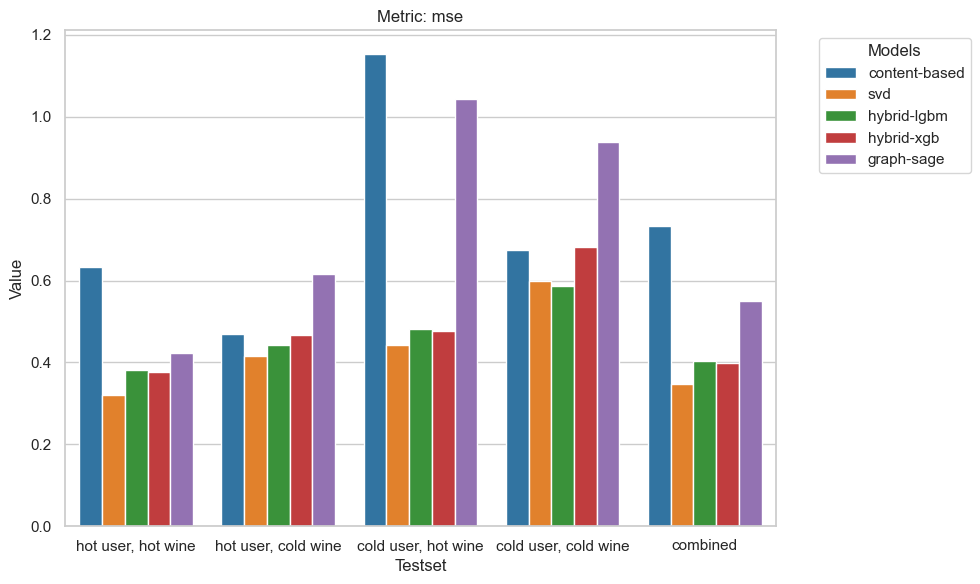

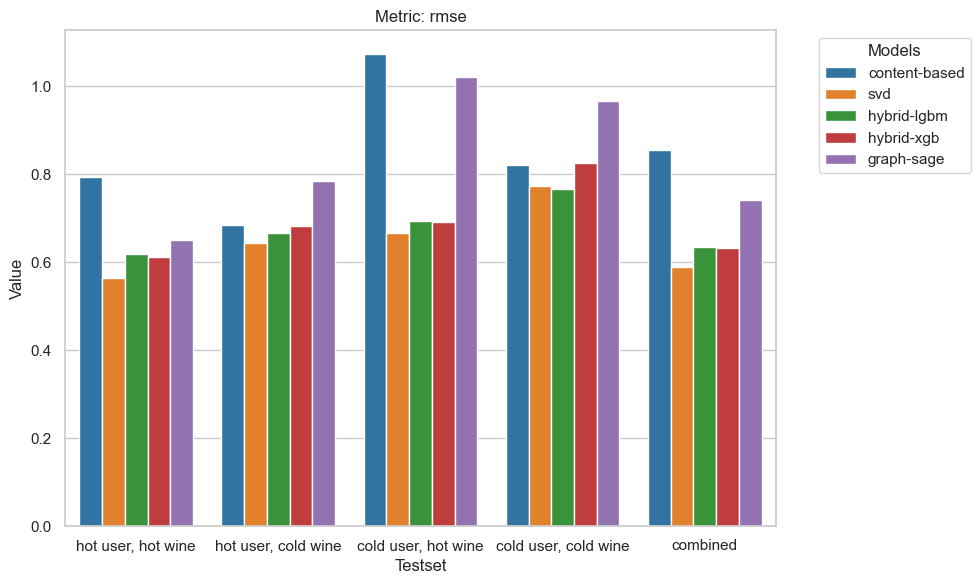

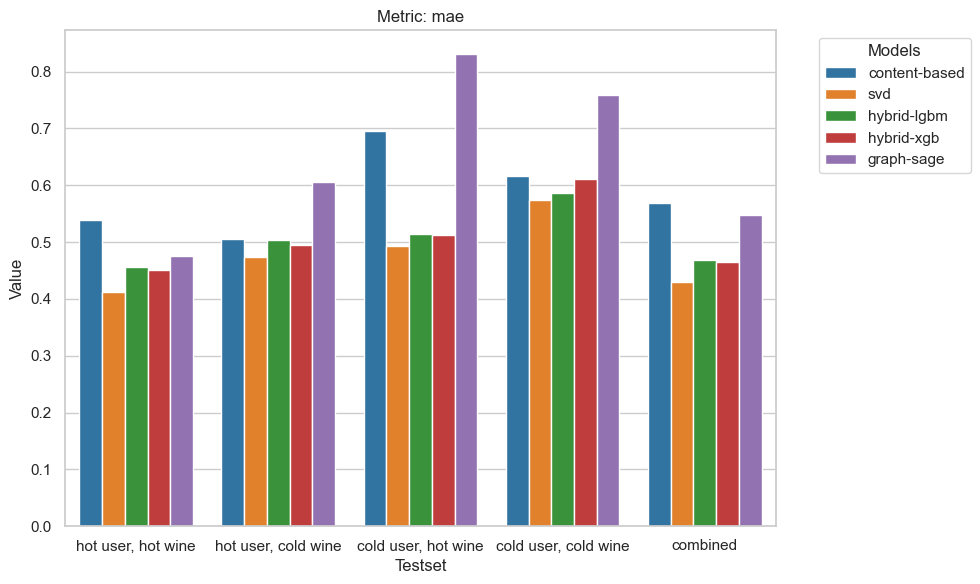

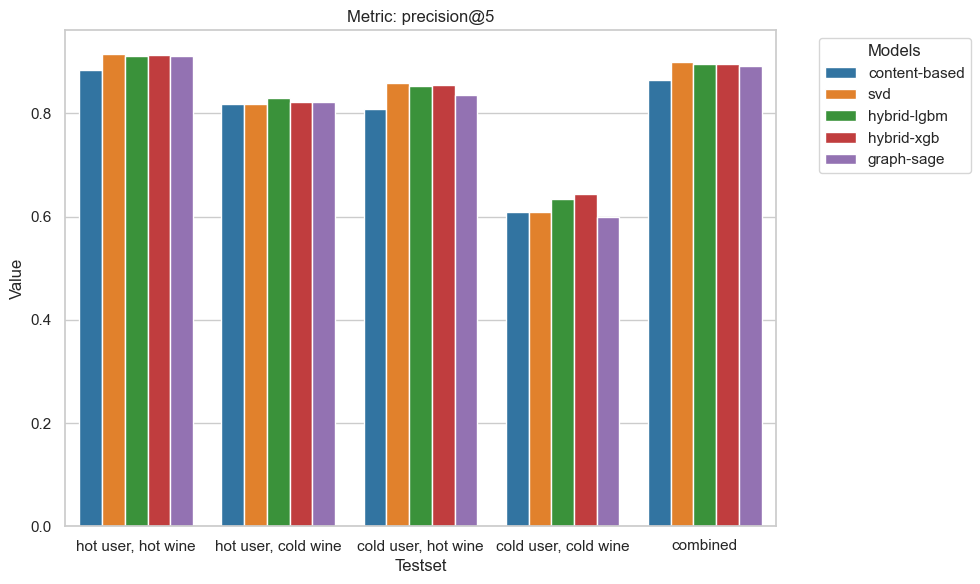

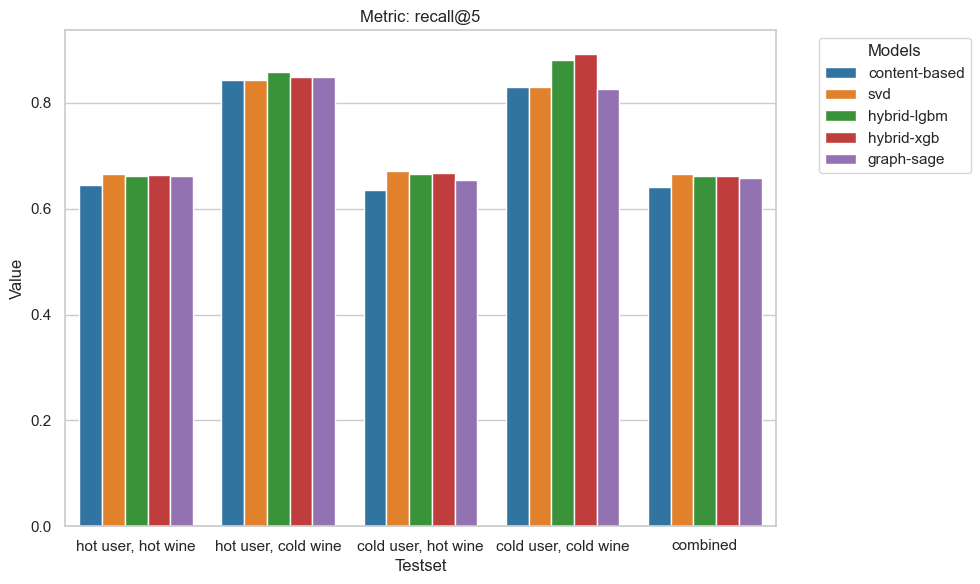

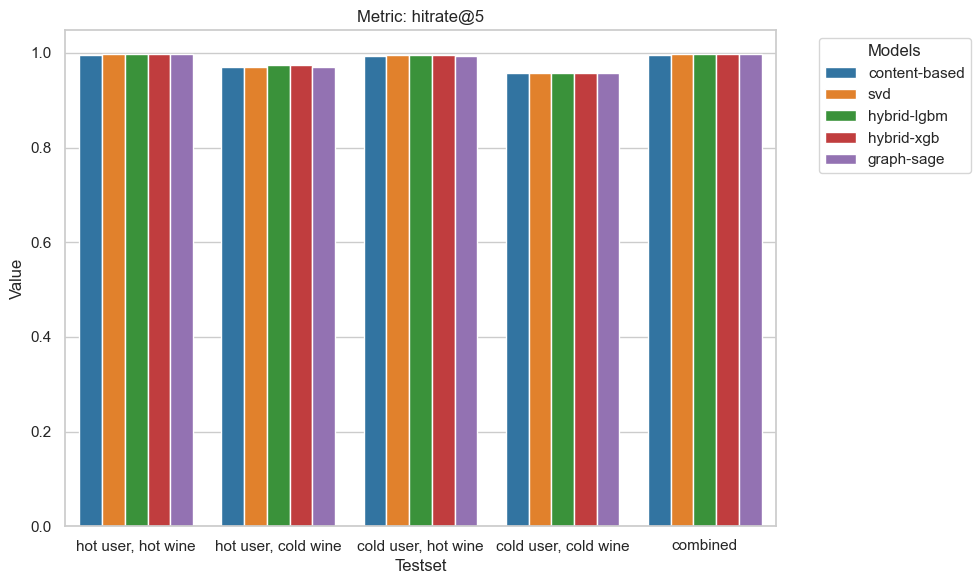

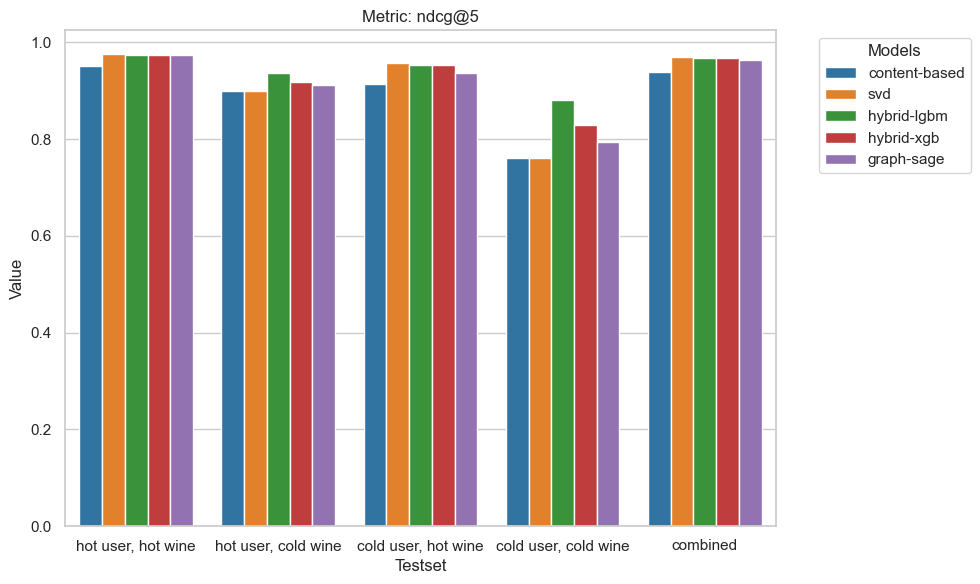

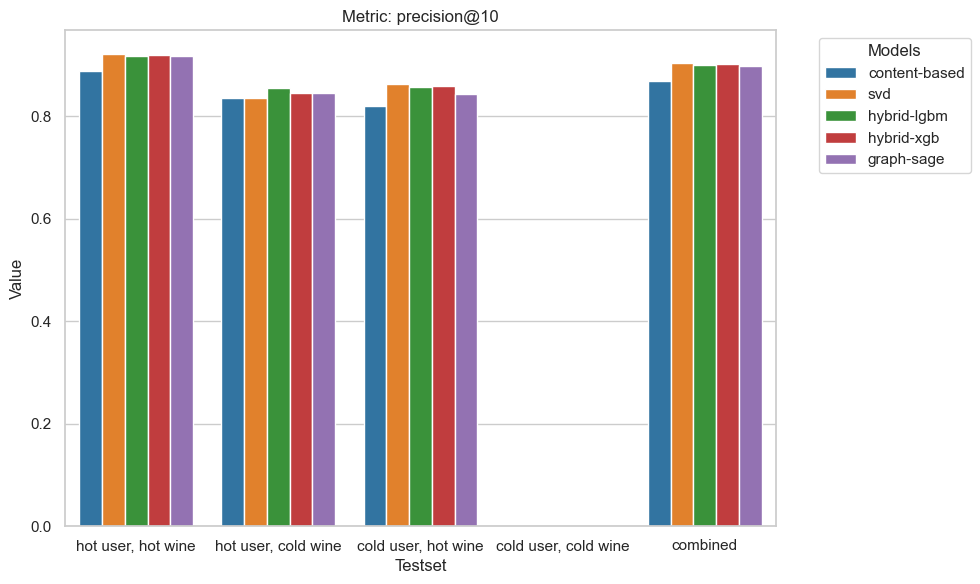

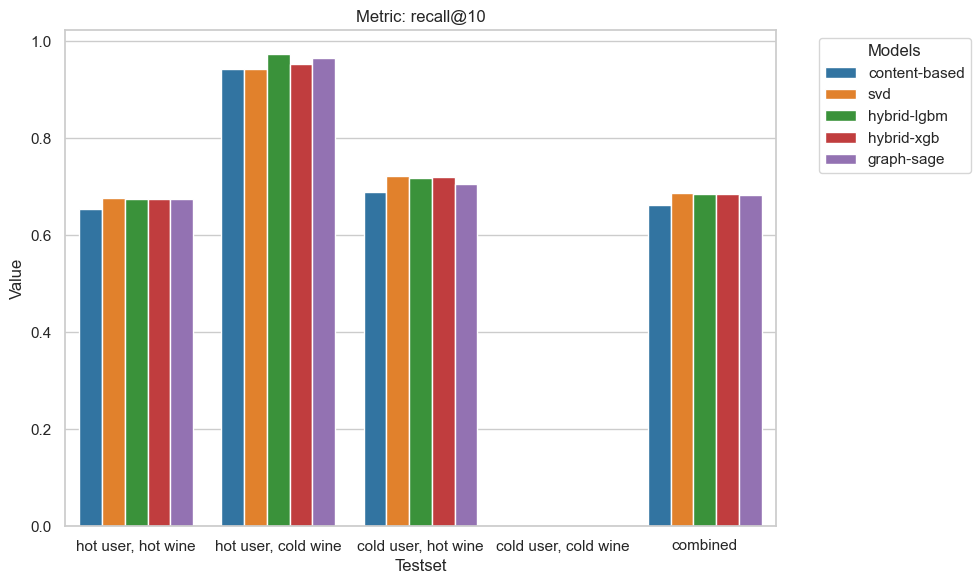

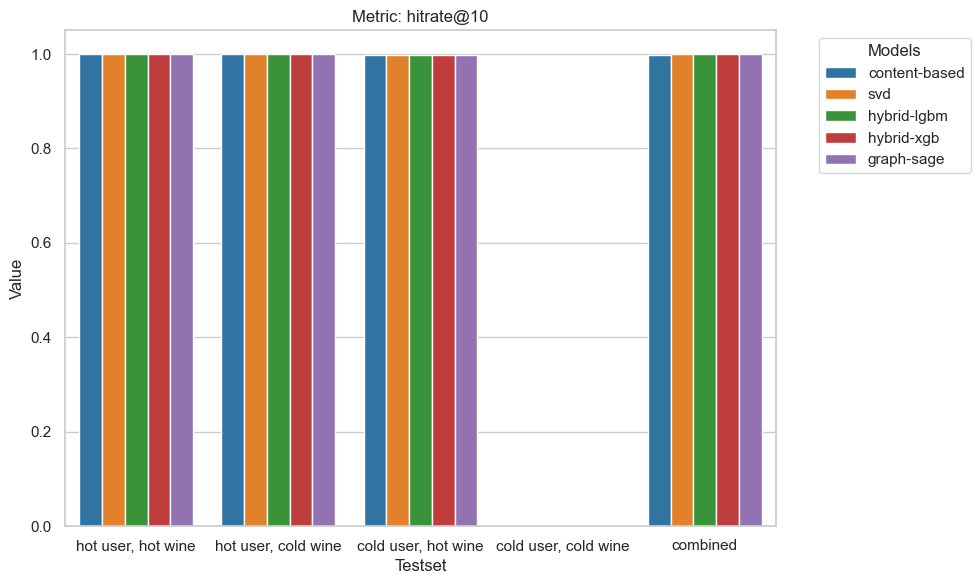

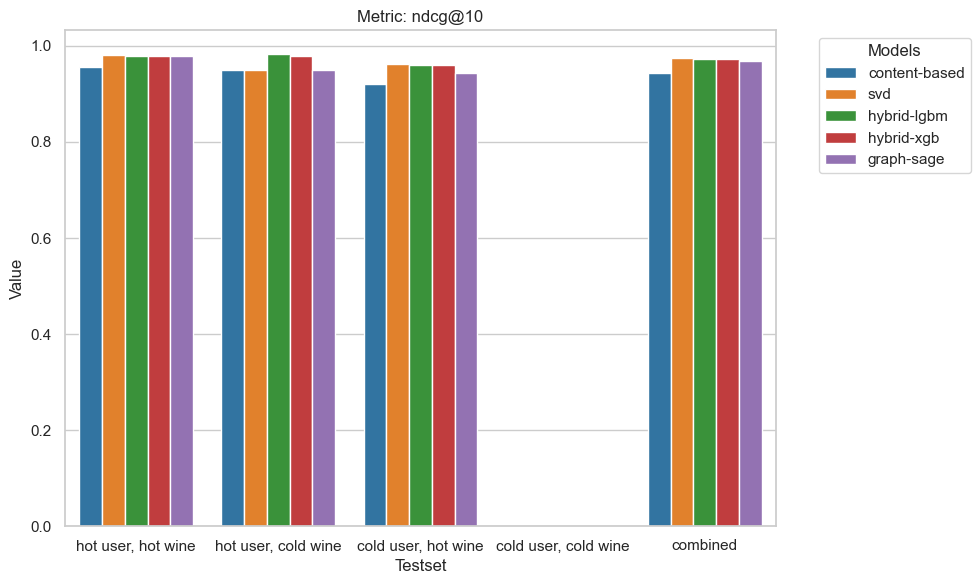

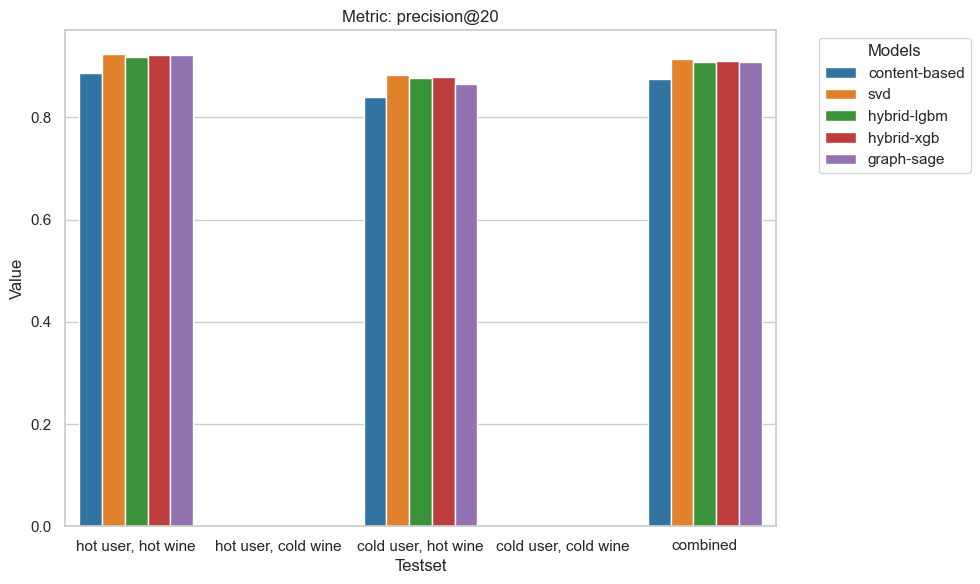

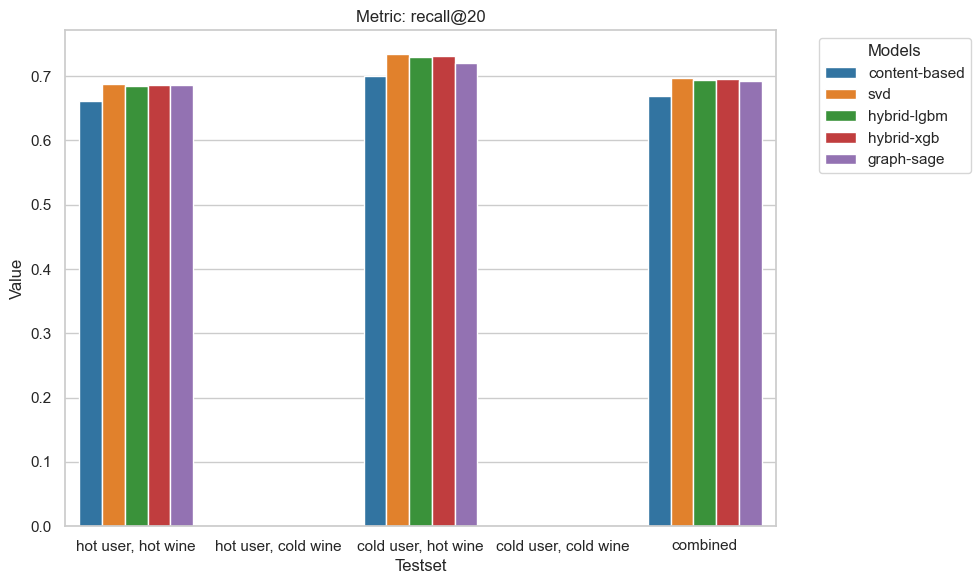

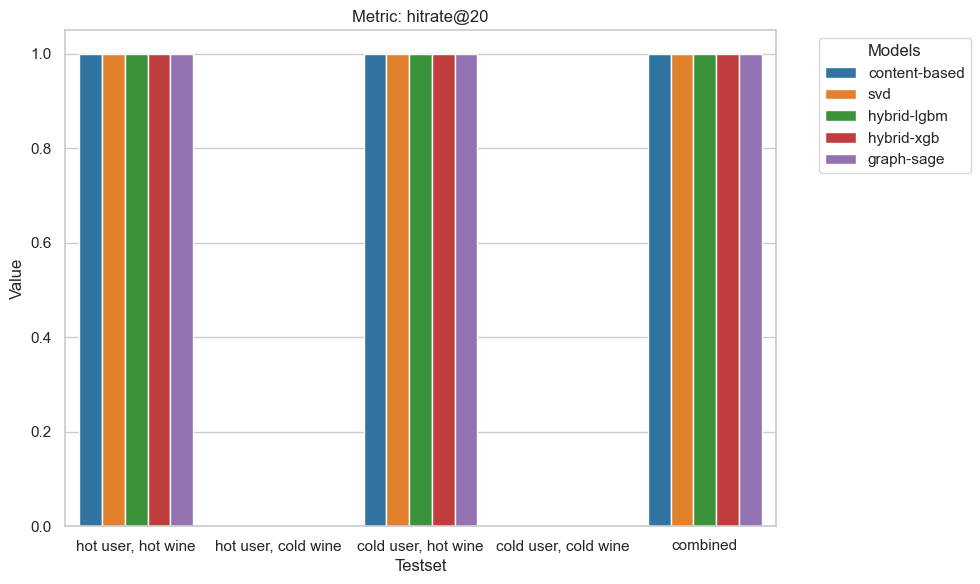

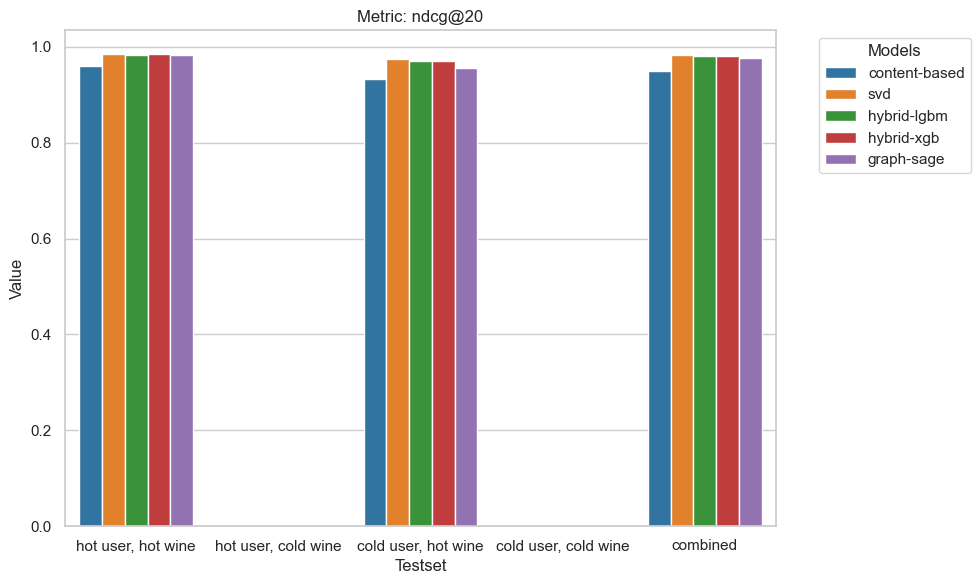

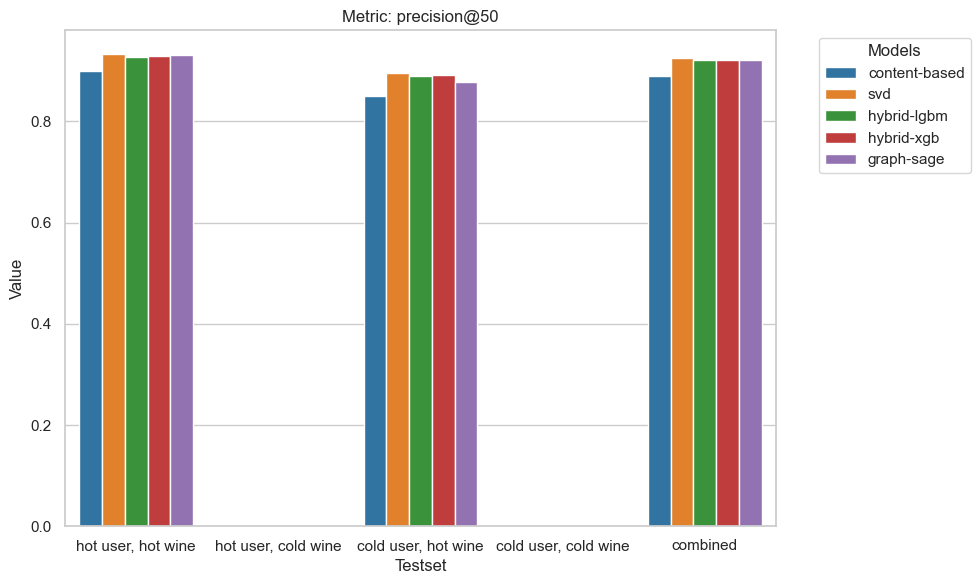

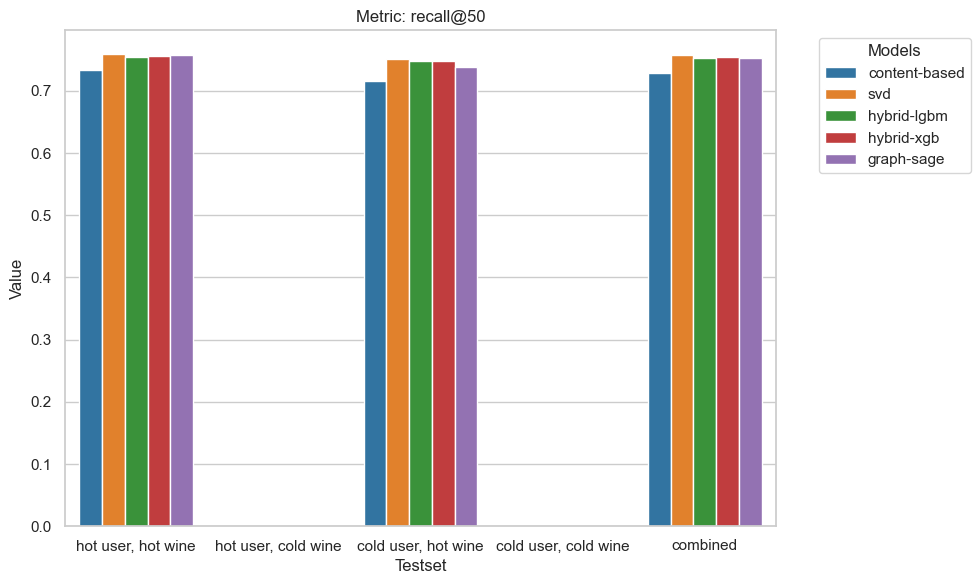

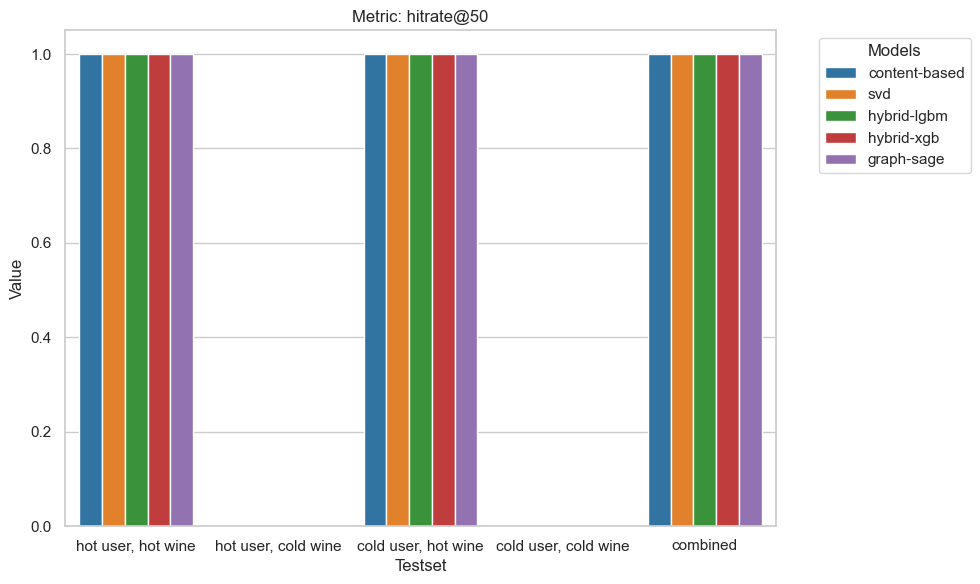

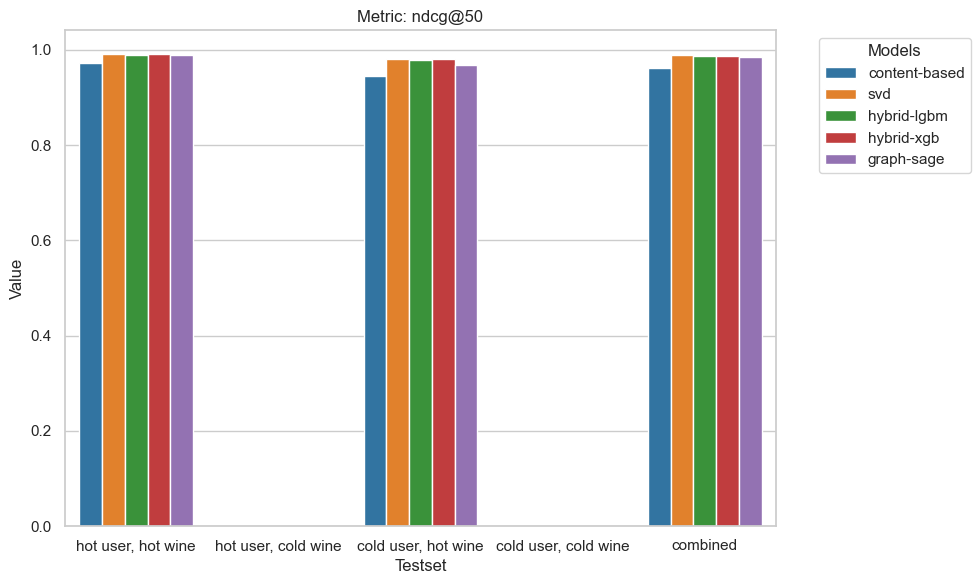

In [23]:
sns.set(style="whitegrid")

for metric in df_plot['Metric'].unique():
    plt.figure(figsize=(10, 6))
    metric_df = df_plot[df_plot['Metric'] == metric]
    
    ax = sns.barplot(
        data=metric_df,
        x='Testset',
        y='Value',
        hue='Model',
        palette='tab10'
    )
    
    plt.title(f'Metric: {metric}')
    plt.ylabel('Value')
    plt.xlabel('Testset')
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Results on different testsets by model

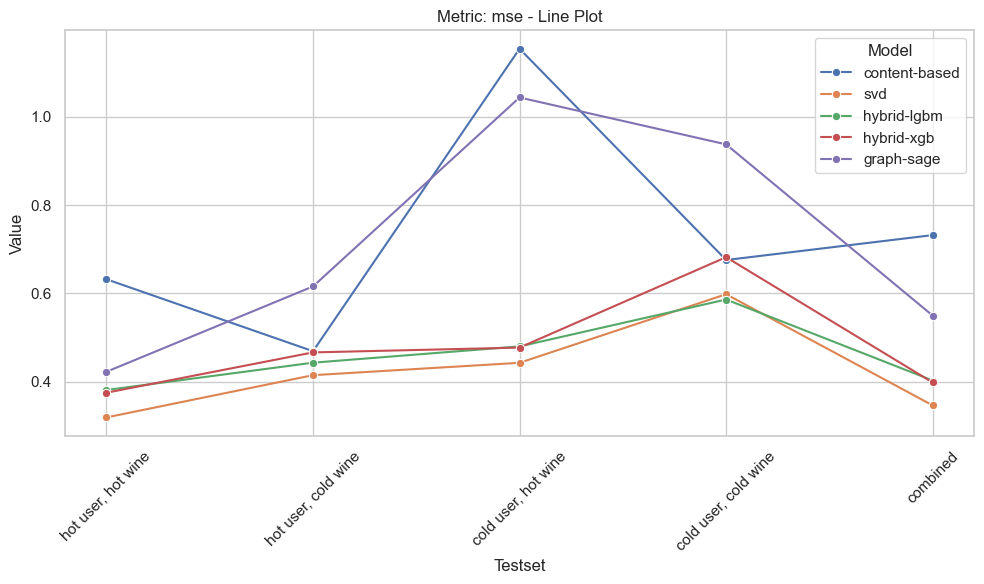

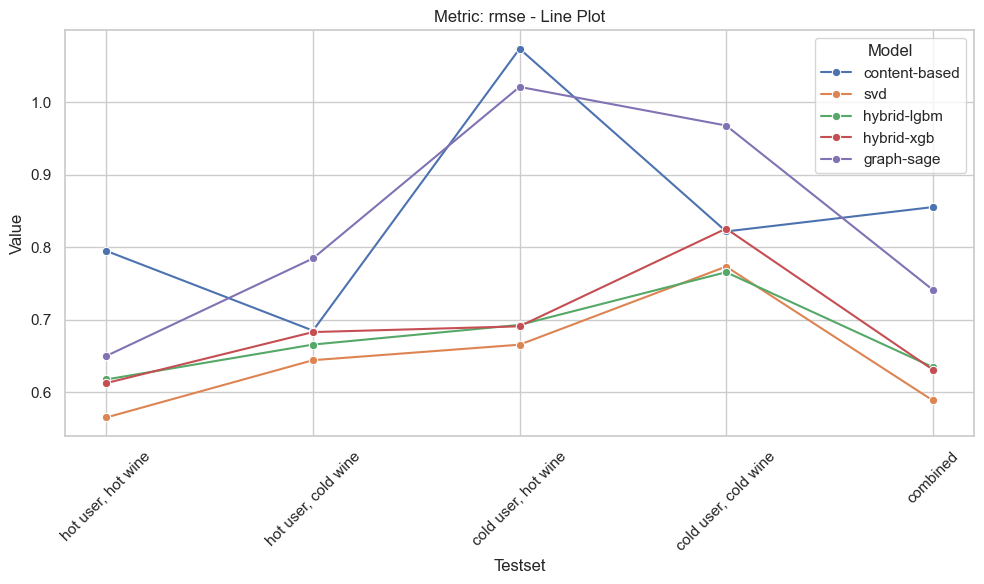

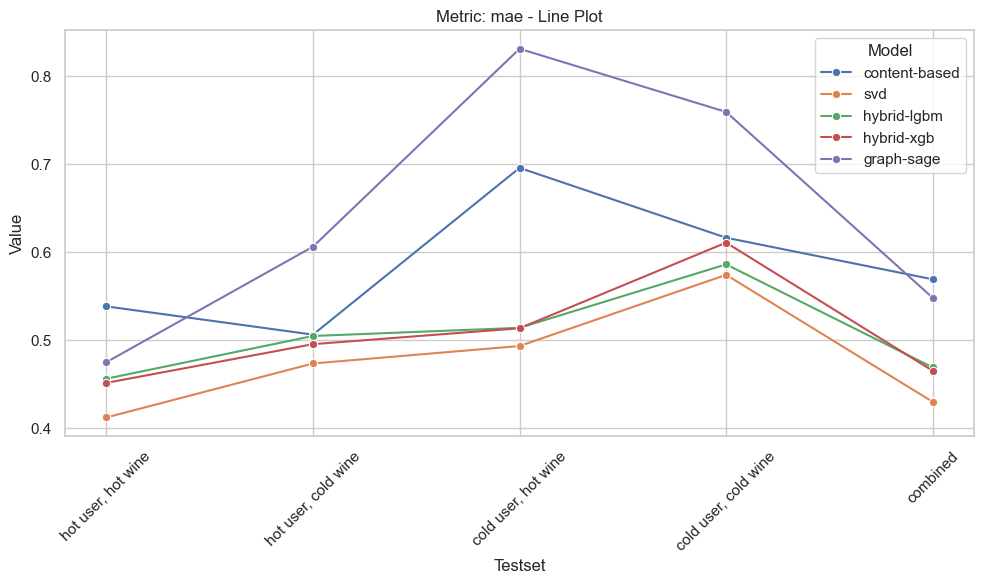

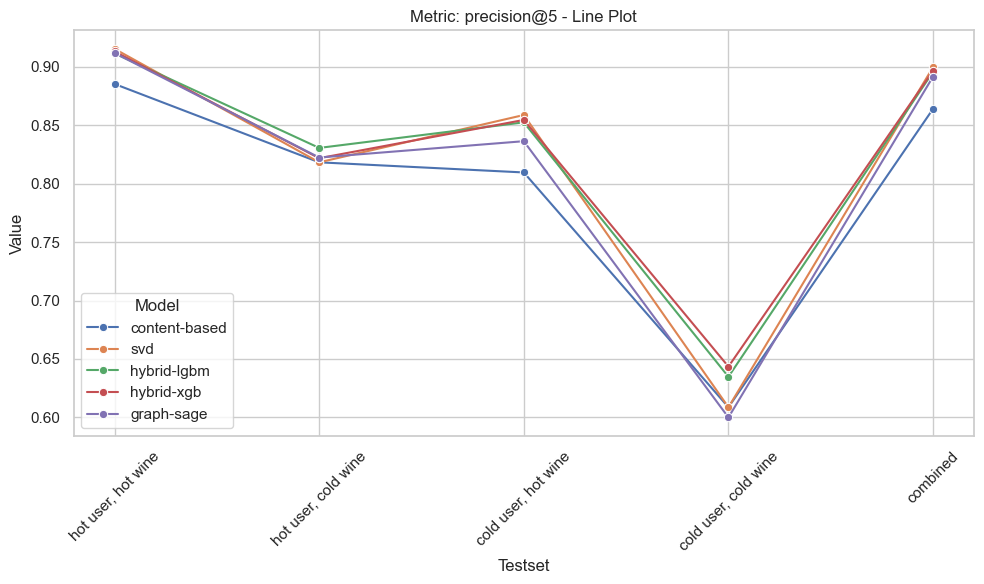

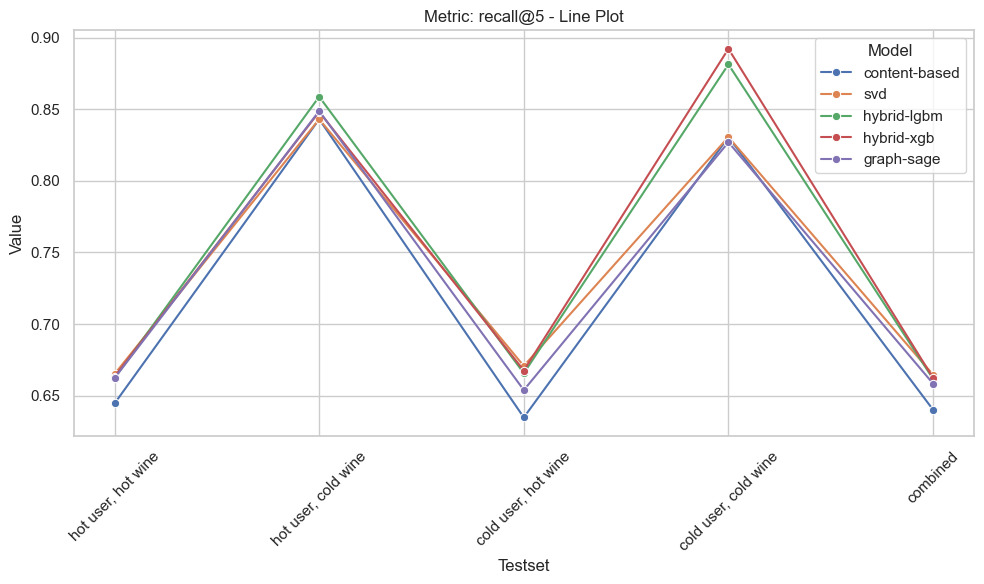

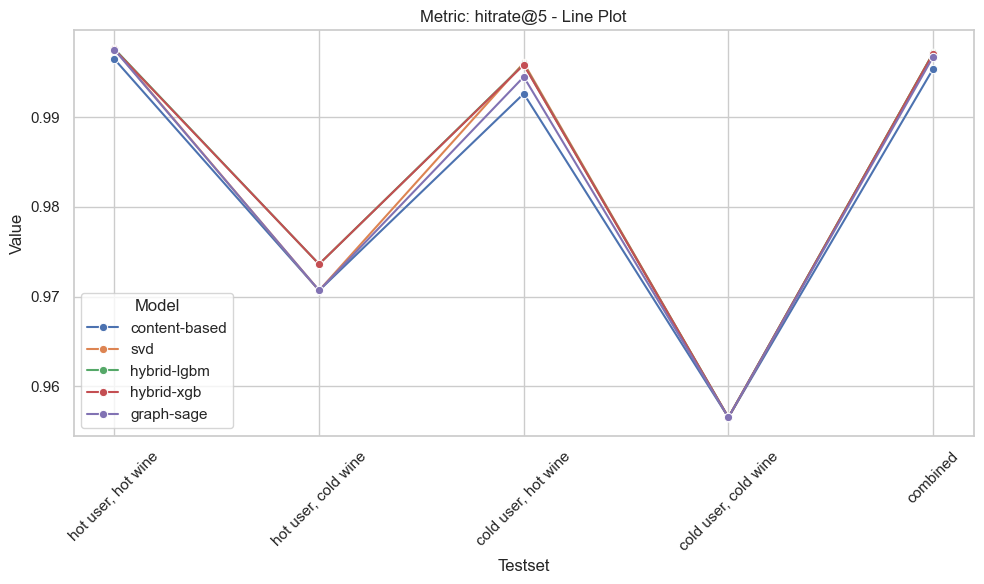

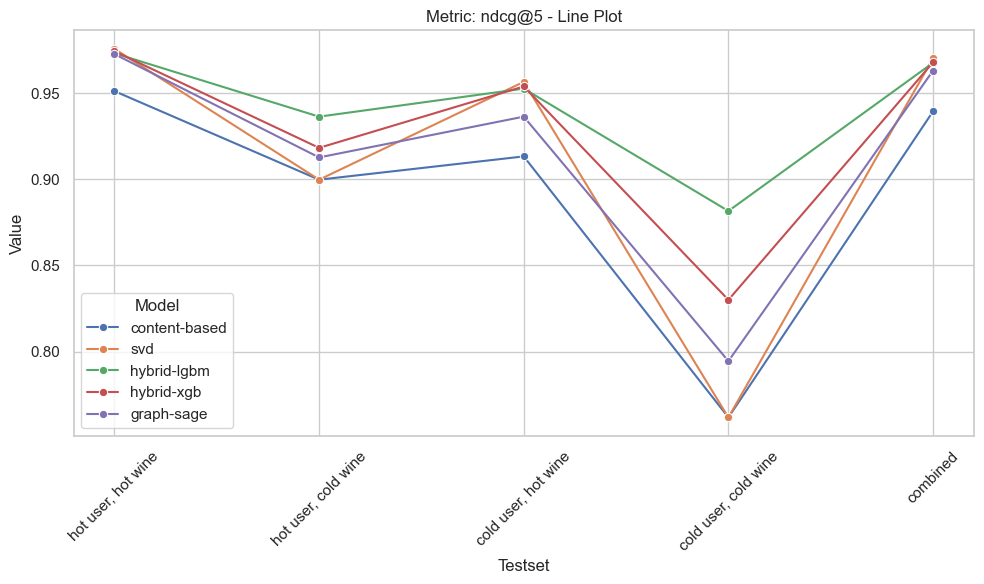

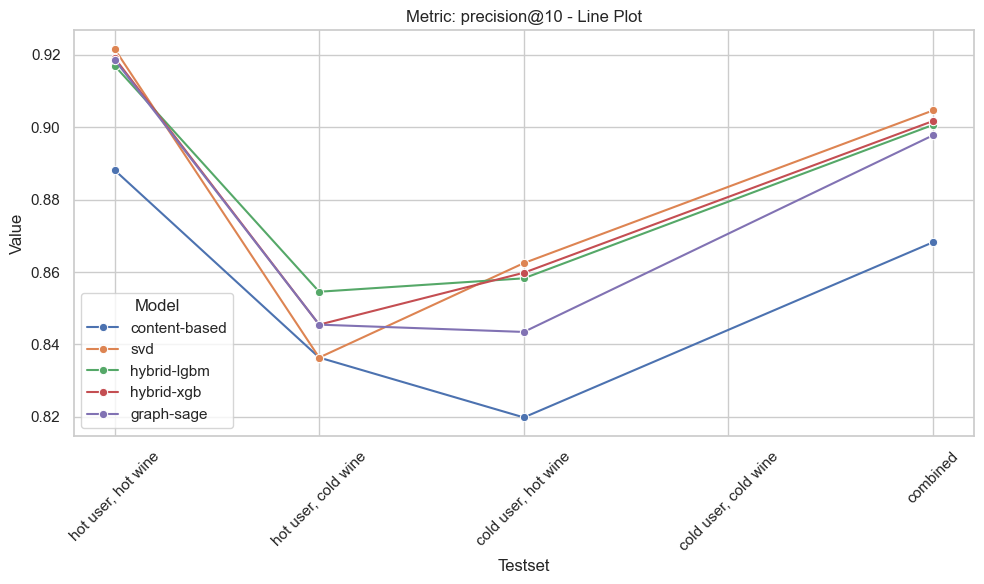

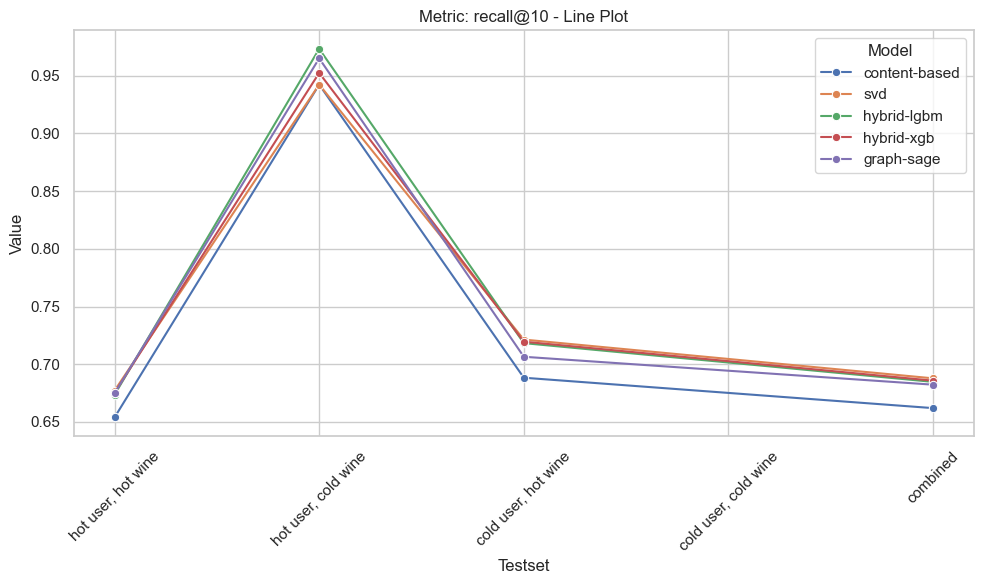

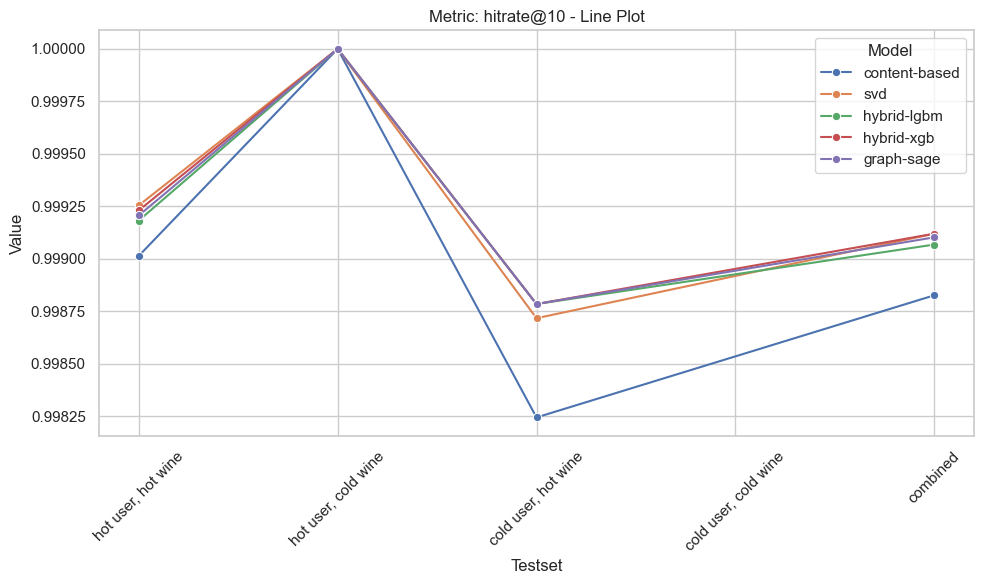

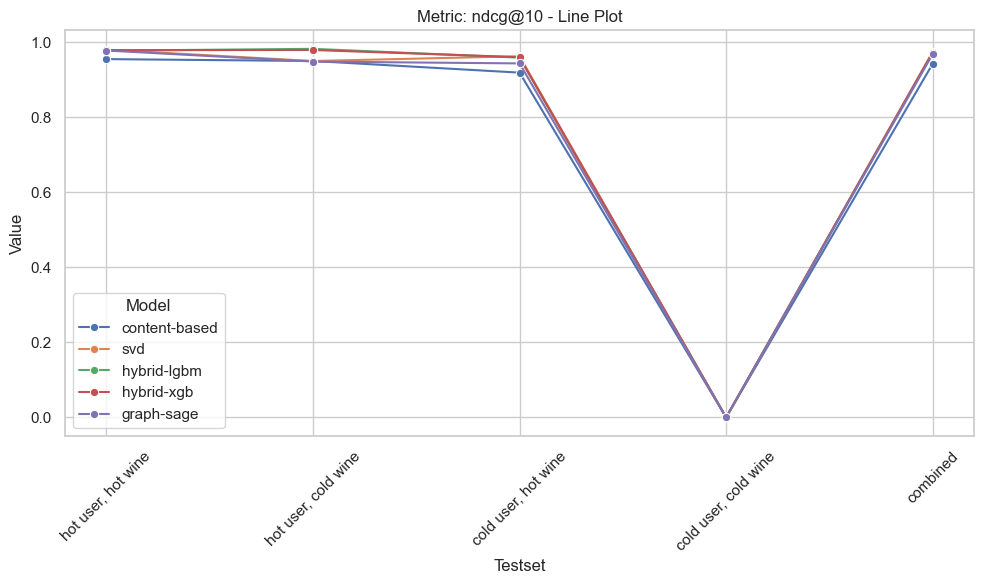

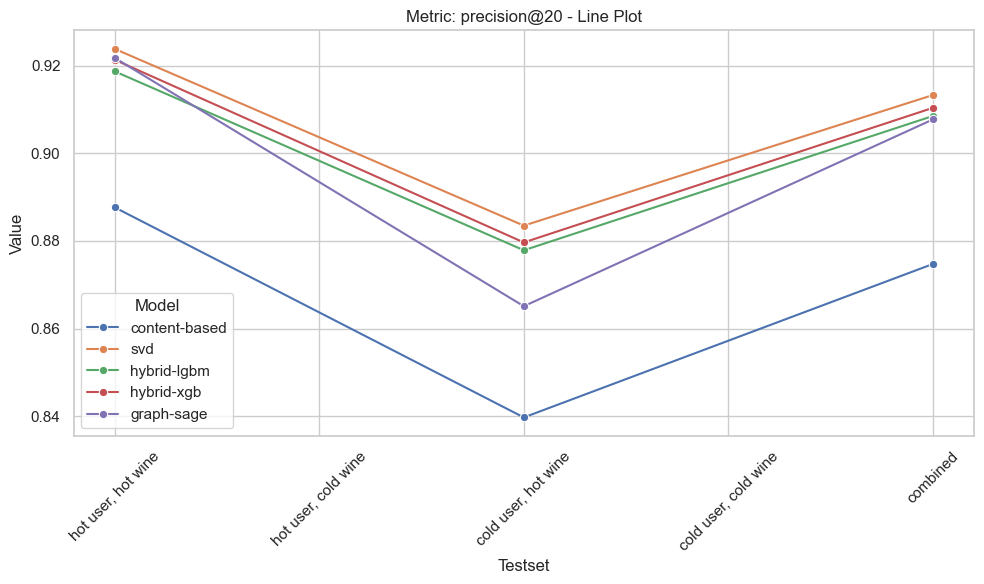

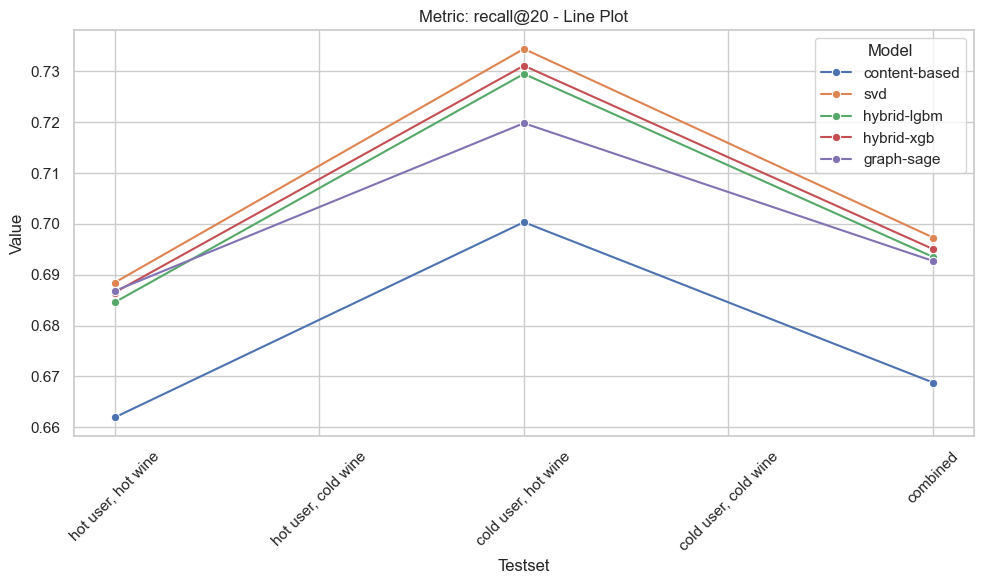

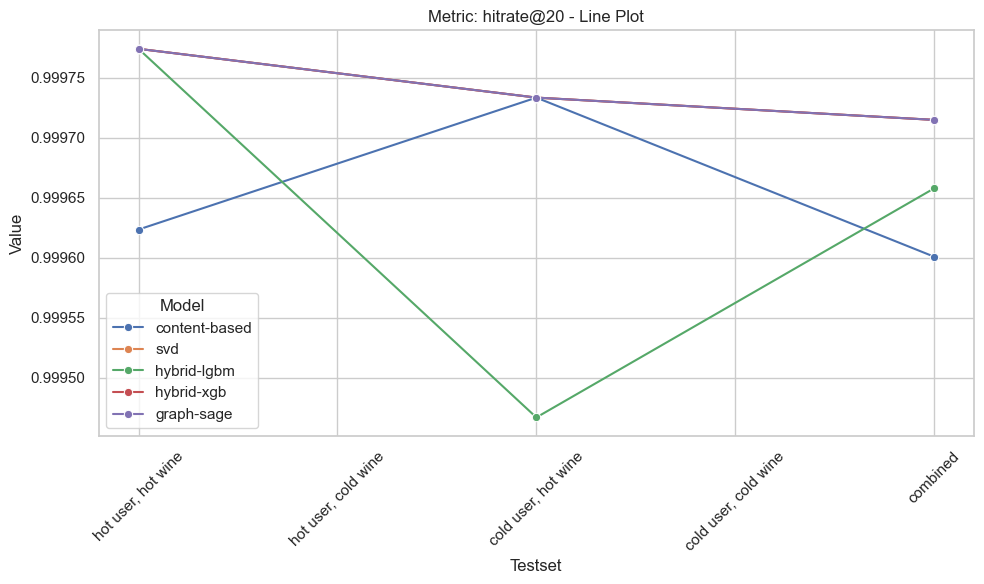

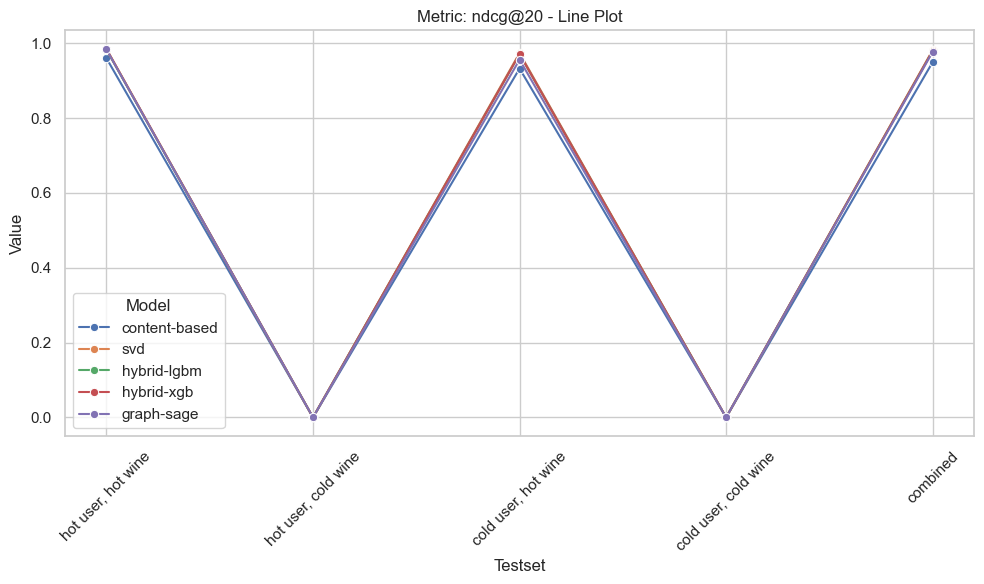

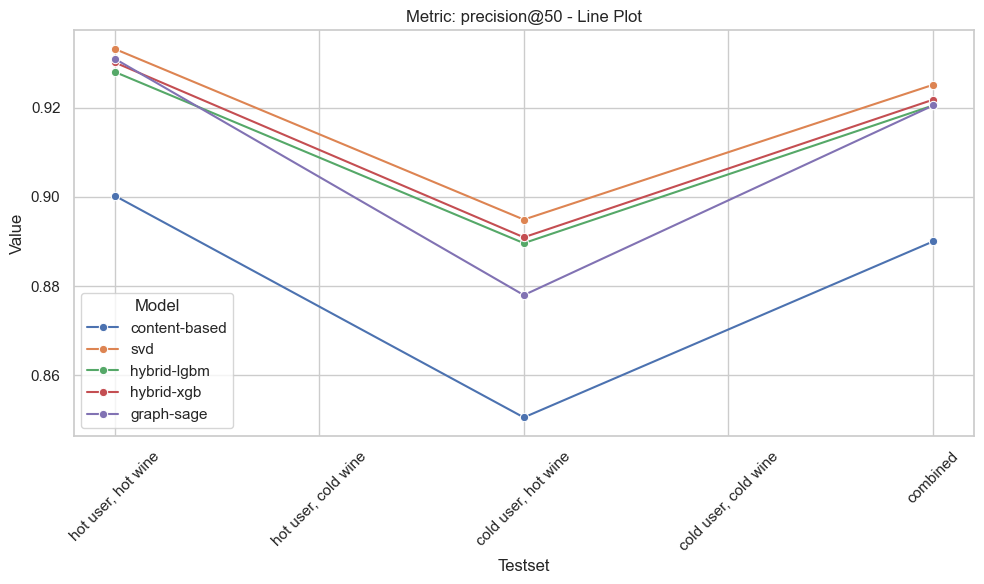

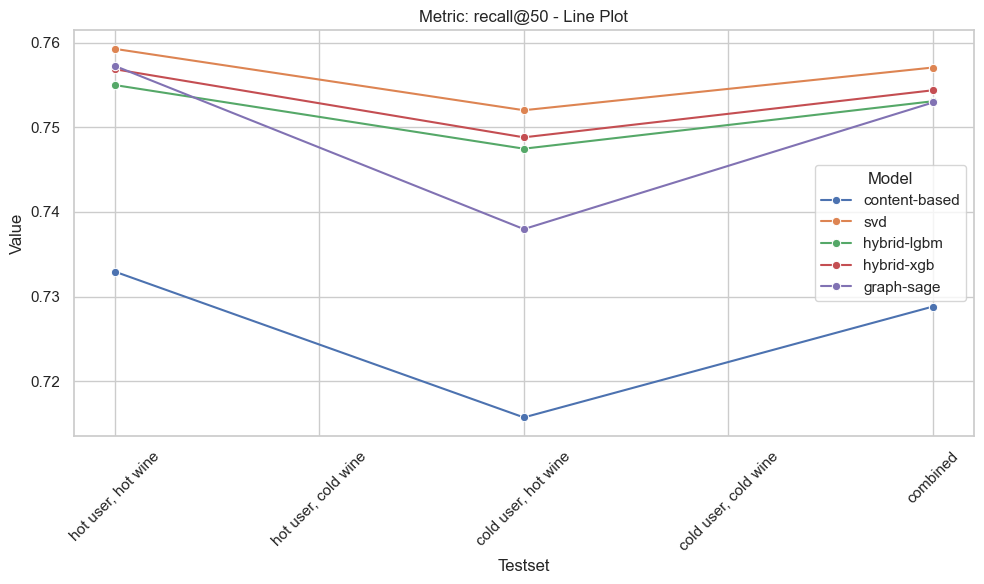

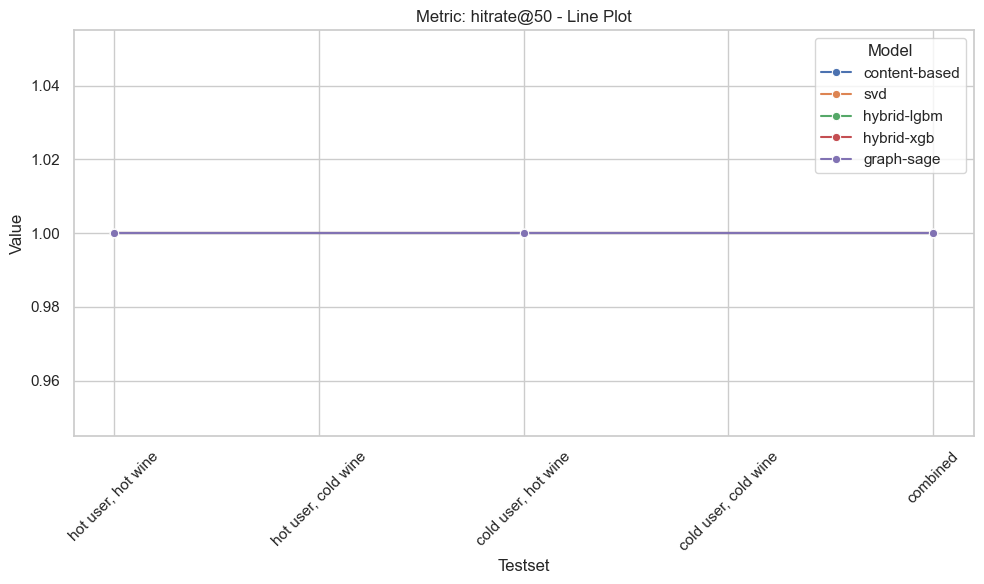

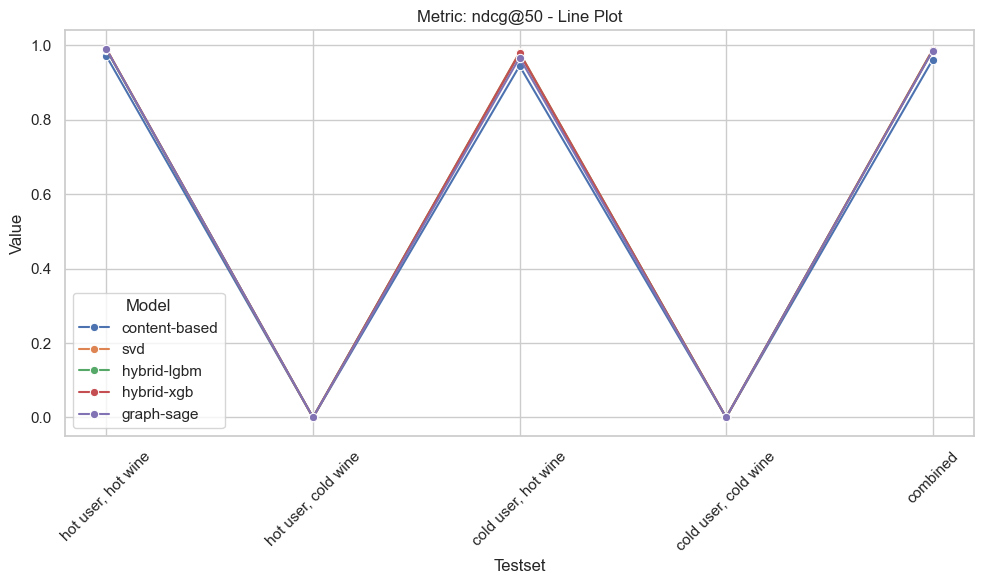

In [24]:
for metric in df_plot['Metric'].unique():
    metric_df = df_plot[df_plot['Metric'] == metric]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=metric_df, x='Testset', y='Value', hue='Model', marker='o')
    plt.title(f'Metric: {metric} - Line Plot')
    plt.xticks(rotation=45)
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
